# Recommendation Systems - Matrix Factorization

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import zipfile
import urllib.request
import io
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


In [15]:
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
resp = urllib.request.urlopen(url)
zipbytes = resp.read()

z = zipfile.ZipFile(io.BytesIO(zipbytes))
ratings = pd.read_csv(z.open("ml-latest-small/ratings.csv"))
ratings = ratings.drop(columns=["timestamp"])

print("Dataset loaded:", ratings.shape)
ratings.head()

Dataset loaded: (100836, 3)


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## User Item Matrix 

In [16]:
user_item_matrix = ratings.pivot_table(
    index="userId",
    columns="movieId",
    values="rating"
).fillna(0)

print("Matrix shape:", user_item_matrix.shape)

Matrix shape: (610, 9724)


## SVD

In [17]:
svd = TruncatedSVD(n_components=20, random_state=42)
latent_matrix = svd.fit_transform(user_item_matrix)

print("Latent matrix shape:", latent_matrix.shape)

Latent matrix shape: (610, 20)


## Similarity Matrix

In [18]:
user_similarity = cosine_similarity(latent_matrix)
user_similarity_df = pd.DataFrame(
    user_similarity, 
    index=user_item_matrix.index,
    columns=user_item_matrix.index
)

## Recommmendation Function

In [19]:
def recommend_movies(user_id, num_recommendations=5):
    # Find similar users
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:6].index
    
    # Movies rated by target user
    user_movies = ratings[ratings["userId"] == user_id]["movieId"].unique()
    
    # Aggregate movies liked by similar users
    similar_users_movies = ratings[
        ratings["userId"].isin(similar_users)
    ].groupby("movieId")["rating"].mean()
    
    # Remove already watched movies
    recommendations = similar_users_movies.drop(user_movies, errors="ignore")
    
    # Top recommended movies
    top_recommend = recommendations.sort_values(ascending=False).head(num_recommendations)
    return top_recommend

## Recommendation

In [20]:
print("\nTop Recommendations for User 1:")
print(recommend_movies(1))


Top Recommendations for User 1:
movieId
7153    5.0
2890    5.0
555     5.0
2195    5.0
2278    5.0
Name: rating, dtype: float64


## Visualization


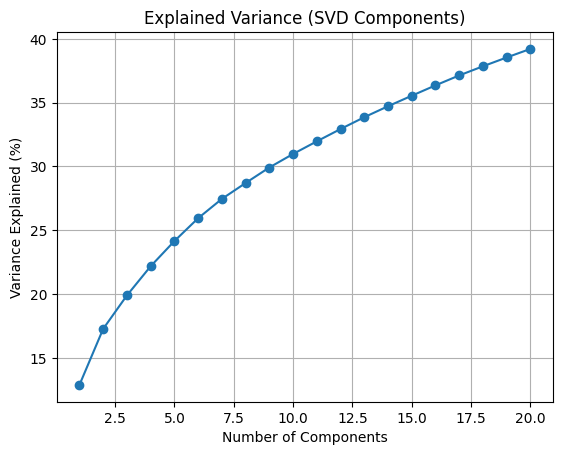

In [21]:
explained = np.cumsum(svd.explained_variance_ratio_) * 100
plt.plot(range(1, len(explained)+1), explained, marker='o')
plt.title("Explained Variance (SVD Components)")
plt.xlabel("Number of Components")
plt.ylabel("Variance Explained (%)")
plt.grid(True)
plt.show()